## Classification with Weighted Sampling
In this notebook, we will train the AlexNet model on our dataset. We will try to mitigate the class imbalance problem by stratified sampling from the dataset based on labels and weighted sampling.

In [1]:
!pip install git+https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git --no-deps

  Cloning https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to /tmp/pip-req-build-p6wdh_pf
  Running command git clone --filter=blob:none --quiet https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git /tmp/pip-req-build-p6wdh_pf
  Resolved https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to commit 6a56bdc472c079e5fbc03eb4ae76259e2bf0c101
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for skin_cancer_detection: filename=skin_cancer_detection-0.1.0-py3-none-any.whl size=5287 sha256=99c6263cdd034753fe37484a6b04f0e393446502303b77823de05291b4add7a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-jmcl451n/wheels/1c/73/8d/15507a4fb68edbf3c8bf56d26a749022d0075ab6b50ec069ff
Successfully built skin_cancer_detection


In [2]:
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import alexnet, vgg16
from torchvision.transforms import v2 as tfs

from exp_tools.basic_utils import init_module, plot_history
from exp_tools.data_utils import HAM10000Dataset, Explorer
from exp_tools.trainer import Trainer

### Loading the Dataset
First, we will load the HAM10000 dataset, both for training and validation.

In [3]:
batch_size = 32
image_size = (224, 224)
transform = tfs.Compose([
    tfs.ToImage(),
    tfs.Resize(image_size),
    tfs.ToDtype(torch.float32, scale=True)
])

In [4]:
local_path = "../data/HMNIST"
kaggle_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

train_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=transform,
    target_transform=torch.tensor,
    split="train"
)
test_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=transform,
    target_transform=torch.tensor,
    split="test"
)
print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Train samples: 8012
Test samples: 2003


#### Weighted Random Sampler
The following sampler class will give more priority to sample belonging to rare classes.

In [5]:
label_weights = 1 / train_set.sample_dist
sample_weights = [
    label_weights[train_set.label_map[label_str]].item()
    for label_str in train_set.metadata.dx
]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_set), replacement=True)

In [6]:
train_dl = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=2)
test_dl = DataLoader(test_set, batch_size=batch_size, num_workers=2)

### Preparing the Model
Now we are going to use AlexNet, a very old model but good for experimentation.

In [11]:
model = alexnet(weights=None, num_classes=len(train_set.label_map))
model.apply(init_module)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Training the Model
Now, we will train our model for possibly 20 epochs.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
metrics = {
    "accuracy": accuracy_score,
    "average_precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro", zero_division=0.0),
    "average_recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro", zero_division=0.0)
} # zero_division parameter is added because it is known that 
trainer = Trainer(
    max_epochs=10, device="cuda", clip_grad=True, clip_val=2.0, metrics=metrics
)

In [13]:
trainer.fit(model, criterion, optimizer, train_dl, test_dl)

Epoch 1/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.8693574284888241
Val loss: 1.7206410863550674
Epoch 2/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.5603881976750869
Val loss: 1.4931776569416924
Epoch 3/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.4130127753130626
Val loss: 1.704205620068642
Epoch 4/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.3884014191177567
Val loss: 1.2621569683476799
Epoch 5/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.2920329129166206
Val loss: 1.3820097359549208
Epoch 6/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.2115459829286166
Val loss: 1.358277159872736
Epoch 7/10
[------------------------------------

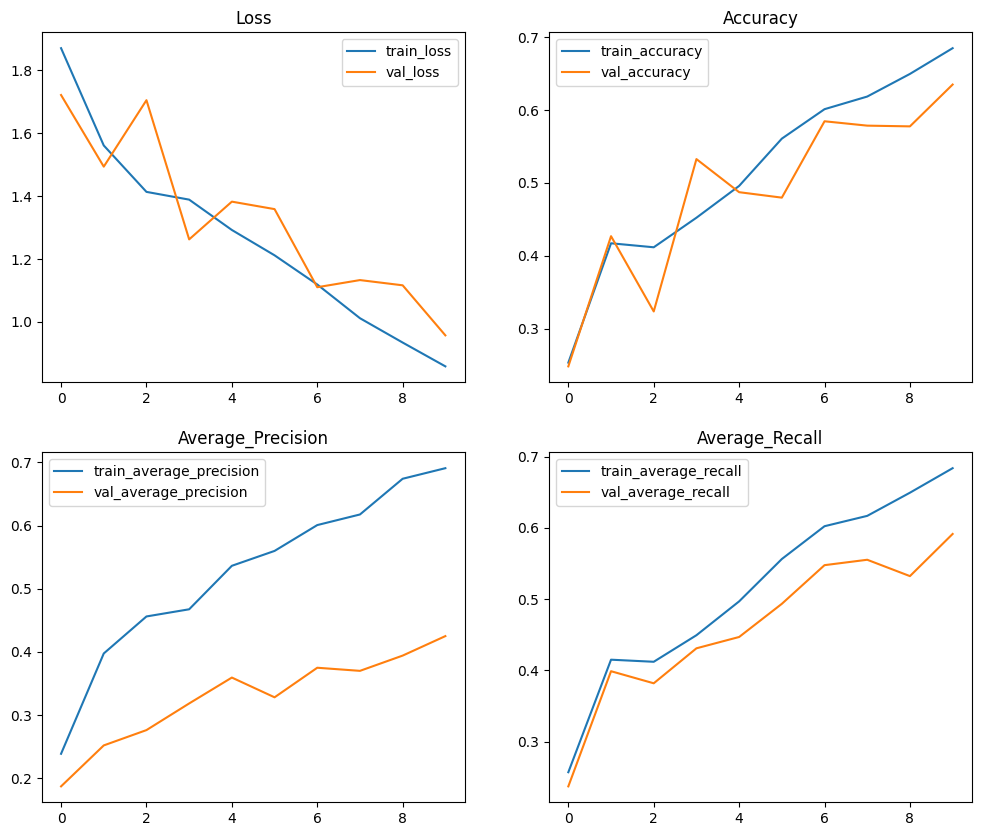

In [14]:
plot_history(trainer.current_history)

So, the results seem okay. So, the training worked with weighted sampling.